In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("online_retail_clean.csv")

print("Shape:", df.shape)
df.head()


Shape: (397925, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34


In [3]:
df.dtypes


Invoice          int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID      int64
Country         object
Revenue        float64
dtype: object

In [4]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")


In [5]:
df["InvoiceDate"].isna().sum()


0

In [8]:
print("Min Quantity:", df["Quantity"].min())
print("Min UnitPrice:", df["Price"].min())
print("Min Revenue:", df["Revenue"].min())
print("Null CustomerID:", df["Customer ID"].isna().sum())


Min Quantity: 1
Min UnitPrice: 0.0
Min Revenue: 0.0
Null CustomerID: 0


In [9]:
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["MonthName"] = df["InvoiceDate"].dt.month_name()


In [10]:
df[["InvoiceDate", "Year", "Month", "MonthName"]].head()


,InvoiceDate,Year,Month,MonthName
0,2010-12-01 08:26:00,2010,12,December
1,2010-12-01 08:26:00,2010,12,December
2,2010-12-01 08:26:00,2010,12,December
3,2010-12-01 08:26:00,2010,12,December
4,2010-12-01 08:26:00,2010,12,December


In [15]:
df = df[(df["Price"] > 0) & (df["Revenue"] > 0)]
df[["Price", "Revenue"]].min()
#df.shape
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,Year,Month,MonthName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,December
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,December
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,December
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,December
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,December


In [18]:
invoice_df = (
    df
    .groupby("Invoice")
    .agg(
        InvoiceDate=("InvoiceDate", "min"),
        CustomerID=("Customer ID", "first"),
        Country=("Country", "first"),
        InvoiceRevenue=("Revenue", "sum"),
        TotalItems=("Quantity", "sum"),
        UniqueProducts=("StockCode", "nunique")
    )
    .reset_index()
)

invoice_df["InvoiceRevenue"].mean()
invoice_df["InvoiceRevenue"].median()


303.03999999999996

In [19]:
mean_aov = invoice_df["InvoiceRevenue"].mean()
median_aov = invoice_df["InvoiceRevenue"].median()

mean_aov, median_aov


(480.8669276926398, 303.03999999999996)

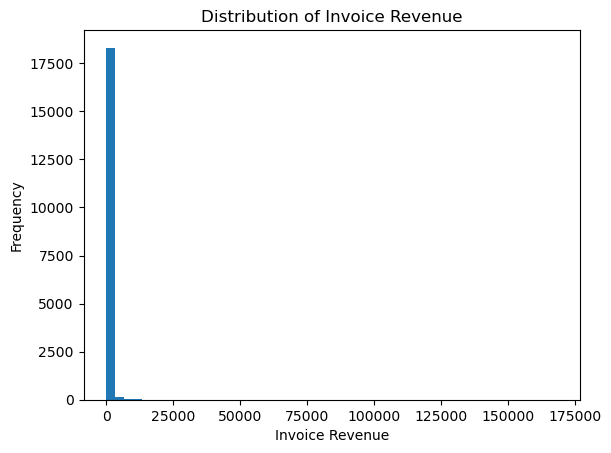

In [21]:
plt.figure()
plt.hist(invoice_df["InvoiceRevenue"], bins=50)
plt.title("Distribution of Invoice Revenue")
plt.xlabel("Invoice Revenue")
plt.ylabel("Frequency")
plt.show()


In [22]:
threshold = invoice_df["InvoiceRevenue"].quantile(0.90)

top_10_pct_revenue = invoice_df.loc[
    invoice_df["InvoiceRevenue"] >= threshold, "InvoiceRevenue"
].sum()

total_revenue = invoice_df["InvoiceRevenue"].sum()

top_10_pct_share = top_10_pct_revenue / total_revenue

top_10_pct_share


0.45274366913481545

In [23]:
invoice_df["IsUK"] = invoice_df["Country"] == "United Kingdom"
invoice_df["IsUK"].value_counts()
invoice_df.groupby("IsUK")["InvoiceRevenue"].mean()


IsUK
False    849.965191
True     439.047913
Name: InvoiceRevenue, dtype: float64

In [24]:
from scipy.stats import mannwhitneyu

uk_revenue = invoice_df.loc[invoice_df["IsUK"], "InvoiceRevenue"]
non_uk_revenue = invoice_df.loc[~invoice_df["IsUK"], "InvoiceRevenue"]

stat, p_value = mannwhitneyu(
    uk_revenue,
    non_uk_revenue,
    alternative="two-sided"
)

stat, p_value


(11276160.0, 1.155983091399055e-89)